# Exploratory Data Analysis with a Synthetic Dataset

## Import Packages

In [25]:
# Web - Scraping and API Requests
import requests


# Data Manipulation and Analysis
import pandas as pd
from pprint import pprint 
import json

# Database Connection
from sqlalchemy import create_engine

# SQL Querying
from sqlalchemy import inspect, text

#  Plotting and Visualization
from plotnine import *
from plotnine.scales import scale_x_date


# File and System Operations
import os
import sys

## Other Setup

In [26]:
pd.set_option('display.max_columns', None) # Display all columns in any given DataFrame

In [27]:
# This allows one to reload the custom package without having to install it again
%load_ext autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# this allows one to reload the custom package without having to install it again
%autoreload 1




### Import Custom Packages

In [29]:
# Change the wd
sys.path.insert(0,'../src/')

#Import the packages
from macro_utils import sql_queries as sqlq
from macro_utils import functions as macro

## Connect to the Database

### Finding the correct file directory for the database credentials json with the api key and password


In [30]:
current_dir = os.path.dirname(os.path.abspath("NB01_Extract_Data.ipynb"))
sys.path.insert(0,os.path.join(current_dir, '..'))

credentials_file_path = os.path.join(current_dir, '..', "supabase_credentials.json")

# open the  credentials file and load the data into a variable
with open(credentials_file_path, "r") as f:
    credentials = json.load(f)

#### Connect to the SupaBase Engine

In [31]:
# connect to the database
supabase_engine = sqlq.get_supabase_engine(
    user="postgres",
    password=credentials['password'],
    host=credentials['host'],
    port=5432,
    database="postgres"
)

### Create an Empty Table and Fill it with the Right Data

In [32]:
# Create a sample DataFrame to play around with
# Generate 12 periods for each country
periods = pd.period_range('2021Q1', periods=12, freq='Q')
yq_list = periods.astype(str).tolist()
countries = ['USA', 'CAN']

data = []
for country in countries:
    for i, yq in enumerate(yq_list):
        level = 100 + i*5 if country == 'USA' else 90 + i*5
        # Have canada diverge from the USA after 6 periods, and then more significantly after 9 periods
        if country == 'CAN' and i >= 6:
            level += i
            level += 2*i
        shortage = 1 if i >= 9 else 0  # last 3 periods have shortage = 1
        data.append({'yq': yq, 'country': country, 'level': level, 'shortage': shortage})

test_data = pd.DataFrame(data)

In [33]:
# Create unique country and yq number codes so as to index data uniquely
# Map countries to 3-digit codes
country_codes = {k: f"{i+1:03}" for i, k in enumerate(test_data['country'].unique())}
test_data['country_lab'] = test_data['country'].map(country_codes)

# Generate within-country quarter numbers (ordered)
test_data['quarter_num'] = test_data.groupby('country').cumcount() + 1  # start at 1
test_data['quarter_num_str'] = test_data['quarter_num'].apply(lambda x: f"{x:05}")

# Combine into a panel ID
test_data['id'] = test_data['country_lab'] + test_data['quarter_num_str']

# convert to integer
test_data['id'] = test_data['id'].astype('int64')

# convert country lab to integer
test_data['country_lab'] = test_data['country_lab'].astype('int16')

# Convert 'yq' to datetime (quarter start)
test_data['quarter_start'] = pd.PeriodIndex(test_data['yq'], freq='Q').to_timestamp()

In [34]:
# keep only the necessary columns and move panel_id_num to the front
test_data = test_data[['id', 'country_lab','country', 'quarter_start', 'yq', 'level', 'shortage']]


test_data

,id,country_lab,country,quarter_start,yq,level,shortage
0,100001,1,USA,2021-01-01,2021Q1,100,0
1,100002,1,USA,2021-04-01,2021Q2,105,0
2,100003,1,USA,2021-07-01,2021Q3,110,0
3,100004,1,USA,2021-10-01,2021Q4,115,0
4,100005,1,USA,2022-01-01,2022Q1,120,0
5,100006,1,USA,2022-04-01,2022Q2,125,0
6,100007,1,USA,2022-07-01,2022Q3,130,0
7,100008,1,USA,2022-10-01,2022Q4,135,0
8,100009,1,USA,2023-01-01,2023Q1,140,0
9,100010,1,USA,2023-04-01,2023Q2,145,1


## Create and use a Function to Dynamically Create a SQL Table

This should automatically detect the columns and types of the data and create a table with the correct column names and types, with only as much data capacity as needed.

In [35]:
def infer_sql_type(series) -> str:
    """
    Infers the appropriate SQL data type for a pandas Series.

    Args:
        series: pd.Series
            The pandas Series for which to infer the SQL type.

    Returns:
        str: The inferred SQL data type as a string.
    """
    # Check if the series is of integer type
    if pd.api.types.is_integer_dtype(series):
        return "INTEGER"
    # Check if the series is of float type
    elif pd.api.types.is_float_dtype(series):
        return "REAL"
    # Check if the series is of boolean type
    elif pd.api.types.is_bool_dtype(series):
        return "BOOLEAN"
    # Check if the series is of datetime type
    elif pd.api.types.is_datetime64_any_dtype(series):
        return "TIMESTAMP"
    else:
        # For object types, infer VARCHAR length or fallback to TEXT
        max_len = series.dropna().astype(str).map(len).max()
        return f"VARCHAR({max_len})" if max_len else "TEXT"

def df_to_create_table_sql(df: pd.DataFrame, table_name: str) -> str:
    """
    Generates a SQL CREATE TABLE statement based on the columns and types of a pandas DataFrame.

    Args:
        df: pd.DataFrame
            The DataFrame to analyze.
        table_name: str
            The name of the SQL table to create.

    Returns:
        str: The SQL CREATE TABLE statement as a string.
    """
    cols = []
    # Iterate through each column to infer its SQL type and build column definitions
    for col in df.columns:
        sql_type = infer_sql_type(df[col])  # Infer the SQL type for the column
            
        # Mark 'id' as PRIMARY KEY if present
        if col == 'id':
            cols.append(f"{col} {sql_type} PRIMARY KEY")
        else:
            cols.append(f"{col} {sql_type}")
    # Join all column definitions into a single string
    col_definitions = ",\n    ".join(cols)
    # Format the final CREATE TABLE SQL statement
    return f"CREATE TABLE IF NOT EXISTS {table_name} (\n    {col_definitions}\n);"


Made changes.

To make the `id` column the primary key in your SQL CREATE TABLE statement, update the function so that when iterating through the DataFrame columns, it adds `PRIMARY KEY` to the `id` column definition. This change has been applied in your notebook.

You can now use the function as before, and if your DataFrame has an `id` column, it will be set as the primary key in the generated SQL.

### Use this Function to Create the Table


In [36]:
CREATE_TABLE_SQL_QUERY = df_to_create_table_sql(test_data, "test_data")
CREATE_TABLE_SQL_QUERY

'CREATE TABLE IF NOT EXISTS test_data (\n    id INTEGER PRIMARY KEY,\n    country_lab INTEGER,\n    country VARCHAR(3),\n    quarter_start TIMESTAMP,\n    yq VARCHAR(6),\n    level INTEGER,\n    shortage INTEGER\n);'

In [37]:
## Drop the table if we wish
with supabase_engine.begin() as connection:
    connection.execute(text("""DROP table IF EXISTS test_data"""))

In [38]:
## Execute the CREATE TABLE query to create a blank table if it doesn't already exist
with supabase_engine.begin() as connection:
    connection.execute(text(CREATE_TABLE_SQL_QUERY))

In [39]:
## find the ids (in this case dates) that already exist
with supabase_engine.connect() as conn:
    existing_ids = conn.execute(text("SELECT id FROM test_data")).fetchall()
## filter out only the ids that will be unique to the existing table
existing_ids = {row[0] for row in existing_ids}
new_rows = test_data[~test_data['id'].isin(existing_ids)]

In [40]:
# fill in the data into the table
sqlq.make_table(new_rows, "test_data", supabase_engine)

## Analyse the Data

### Load the Data

In [41]:
# Read the data back from the database
with supabase_engine.begin() as connection:
    plot_data = pd.read_sql(text("""SELECT * FROM test_data"""), connection)
# Sort the data by country and quarter_start for better visualization
#plot_data = plot_data.sort_values(by=['country', 'quarter_start'])

### Visualise the different time series for different groupings (countries)

#### Setup the Plotting Environment (Colour Mappings, X axis breaks etc)

In [42]:
# Assign colors to each country
color_palette = ['gold', 'red']
countries = plot_data['country'].unique()
color_mapping = dict(zip(countries, color_palette))


In [43]:
# Create a label mapping for the x axis

# Sort data chronologically and drop duplicates in case of multiple countries
label_df = plot_data[['quarter_start', 'yq']].drop_duplicates().sort_values('quarter_start')

# Choose every 2nd quarter (I might change this later)
label_df_filtered = label_df.iloc[::2]

# Extract breaks and labels
yq_breaks = label_df_filtered['quarter_start'].tolist()
yq_labels = label_df_filtered['yq'].tolist()

In [44]:
# Create shaded areas for key periods of interest (by default, labour shortages)
# Create shortage group ID per country using transform

# For each country, identify where the 'shortage' value changes compared to the previous row
plot_data['shortage_grp'] = (
    # Compare current 'shortage' value to previous value within each country
    (plot_data['shortage'] != plot_data.groupby('country')['shortage'].shift())
    # Group by country to ensure changes are tracked separately for each country
    .groupby(plot_data['country'])
    # Cumulatively sum the changes to assign a unique group number for each run of shortage values
    .cumsum()
)

In [45]:
plot_data

,id,country_lab,country,quarter_start,yq,level,shortage,shortage_grp
0,100001,1,USA,2021-01-01,2021Q1,100,0,1
1,100002,1,USA,2021-04-01,2021Q2,105,0,1
2,100003,1,USA,2021-07-01,2021Q3,110,0,1
3,100004,1,USA,2021-10-01,2021Q4,115,0,1
4,100005,1,USA,2022-01-01,2022Q1,120,0,1
5,100006,1,USA,2022-04-01,2022Q2,125,0,1
6,100007,1,USA,2022-07-01,2022Q3,130,0,1
7,100008,1,USA,2022-10-01,2022Q4,135,0,1
8,100009,1,USA,2023-01-01,2023Q1,140,0,1
9,100010,1,USA,2023-04-01,2023Q2,145,1,2


In [46]:
# Calculate min and max quarter_start for each shortage group

# Filter to only rows with shortage == 1
shortage_data = plot_data[plot_data['shortage'] == 1].copy()

# create a separate daframe to store this
shortage_ranges = (
    shortage_data
    .groupby(['country', 'shortage_grp']) # Group by country and shortage group
    .agg(xmin=('quarter_start', 'min'), # for each country and shortage group combination, 
         # get the min and max quarter_start
         xmax=('quarter_start', lambda x: x.max() + pd.Timedelta(days=90))) # Approx. one quarter later = 90 days
    .reset_index()
)

In [47]:
shortage_ranges

,country,shortage_grp,xmin,xmax
0,CAN,2,2023-04-01,2023-12-30
1,USA,2,2023-04-01,2023-12-30


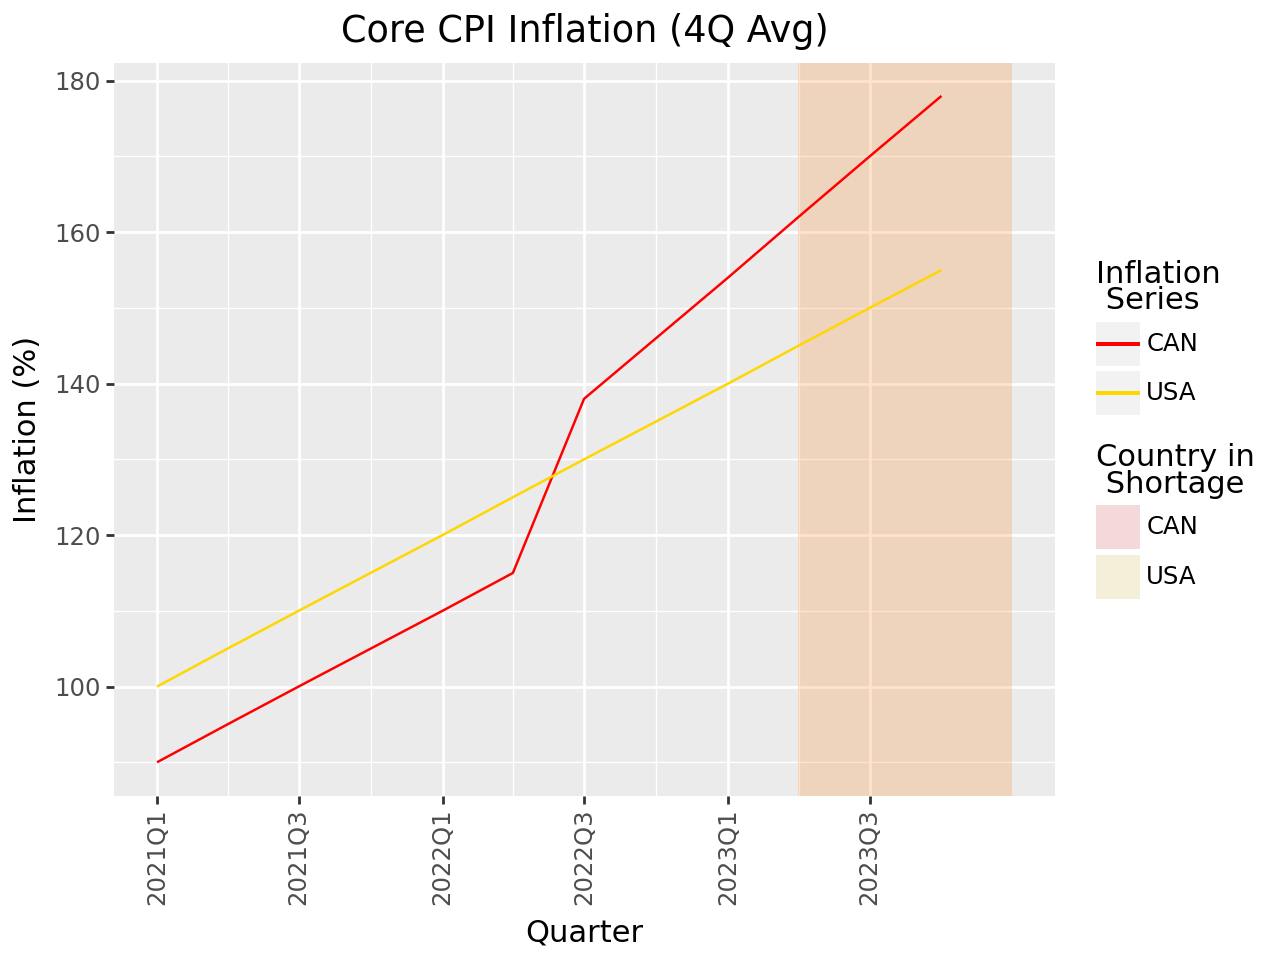

In [62]:
# Plot with ggplot/grammar of graphics using plotnine
g = (
    ggplot(plot_data, aes(x='quarter_start', y='level', color='country')) +
    geom_rect(
        data=shortage_ranges,
        inherit_aes=False,
        mapping=aes(
            xmin='xmin',
            xmax='xmax',
            ymin=-float('inf'),
            ymax=float('inf'),
            fill='country'
        ),
        alpha=0.10
    ) +
    geom_line() +
    scale_color_manual(name = "Inflation \n Series",values=color_mapping) +
    scale_fill_manual(name = "Country in \n Shortage", values=color_mapping) +
    scale_x_date(breaks=yq_breaks, labels=yq_labels) +
    labs(title='Core CPI Inflation (4Q Avg)',
         x='Quarter',
         y='Inflation (%)',
         color='Country') +
    theme(
        axis_text_x=element_text(rotation=90, ha='center')
    ) +
    # Remove linetype legend (or other legends if needed)
    guides(linetype=None)

    

)
g
